# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://ramp.r0h.eu/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
# !pip install -U seaborn  # if you don't have it, or pip3 for python3

In [3]:
# optional
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

First we load `problem.py` that parameterizes the challenge. It contains some objects taken off the shelf from `ramp-workflow` (e.g., `Predictions` type, scores, and data reader). 

In [4]:
problem = imp.load_source('', 'problem.py')

`get_train_data` loads the training data and returns an `pandas` object (input) and a `np.array` object (output).

In [5]:
X_df, y_array = problem.get_train_data()

In [6]:
print(min(X_df['DateOfDeparture']))
print(max(X_df['DateOfDeparture']))

2011-09-01
2013-03-05


In [7]:
X_df.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [8]:
X_df['Departure'].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

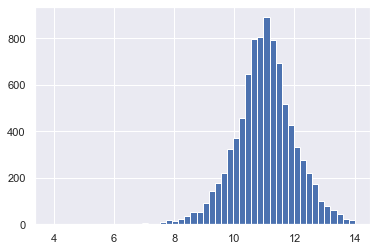

In [9]:
plt.hist(y_array, bins=50);

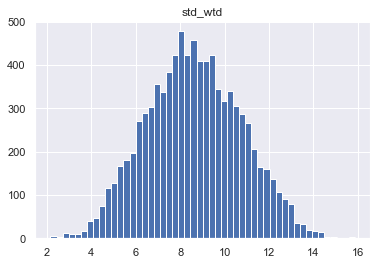

In [10]:
X_df.hist('std_wtd', bins=50);

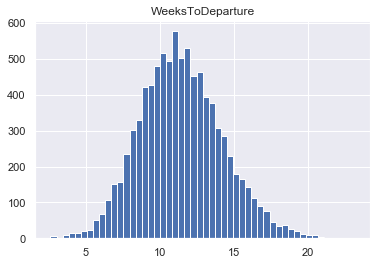

In [11]:
X_df.hist('WeeksToDeparture', bins=50);

In [12]:
X_df.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [13]:
X_df.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
std_wtd             float64
dtype: object

In [14]:
X_df.shape

(8902, 5)

In [15]:
print(y_array.mean())
print(y_array.std())

10.99904767212102
0.9938894125318564


## Preprocessing for prediction

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

In [16]:
X_encoded = X_df

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
X_encoded = X_encoded.drop('Departure', axis=1)
X_encoded = X_encoded.drop('Arrival', axis=1)

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

In [17]:
X_encoded.tail(5)

,DateOfDeparture,WeeksToDeparture,std_wtd,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
8897,2011-10-02,9.263158,7.316967,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,10,2,6,39,15249,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8898,2012-09-25,12.772727,10.641034,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2012,9,25,1,39,15608,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8899,2012-01-19,11.047619,7.908705,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2012,1,19,3,3,15358,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8900,2013-02-03,6.076923,4.030334,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2013,2,3,6,5,15739,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8901,2011-11-26,9.526316,6.167733,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,11,26,5,47,15304,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### A linear regressor baseline

We drop the target column and the original data column.

In [18]:
features = X_encoded.drop(['DateOfDeparture'], axis=1)
X_columns = features.columns
X_array = features.values

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_array, y_array, test_size=0.4, random_state=0)

It gives us a pretty nice improvement above baseline

In [20]:
 from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

reg = LinearRegression()

scores = cross_val_score(
    reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6331 +/- 0.0123


Exercise: Visualize the coefficients, try to make sense of them.

In [21]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
reg.coef_

array([ 1.28119286e-01, -7.53583163e-02,  2.13816508e+09,  2.13816508e+09,
        2.13816508e+09,  2.13816508e+09,  2.13816508e+09,  2.13816508e+09,
        2.13816508e+09,  2.13816508e+09,  2.13816508e+09,  2.13816508e+09,
        2.13816508e+09,  2.13816508e+09,  2.13816508e+09,  2.13816508e+09,
        2.13816508e+09,  2.13816508e+09,  2.13816508e+09,  2.13816508e+09,
        2.13816508e+09,  2.13816508e+09, -1.45188777e+06, -1.45188816e+06,
       -1.45188861e+06, -1.45188814e+06, -1.45188797e+06, -1.45188871e+06,
       -1.45188836e+06, -1.45188888e+06, -1.45188732e+06, -1.45188855e+06,
       -1.45188759e+06, -1.45188721e+06, -1.45188848e+06, -1.45188883e+06,
       -1.45188825e+06, -1.45188747e+06, -1.45188814e+06, -1.45188849e+06,
       -1.45188841e+06, -1.45188774e+06,  7.78925582e+06, -1.16611096e+06,
        1.13214710e+04, -8.40133988e+05,  6.65292815e+04,  9.56915855e-01,
        5.01020168e+06, -2.77940451e+06, -1.05690108e+07, -4.13060272e+06,
       -2.96452188e+06, -

## Random Forests

In [23]:
%%time
from sklearn.ensemble import RandomForestRegressor

n_estimators = 10
max_depth = 10
max_features = 10
reg = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

scores = cross_val_score(
    reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.7586 +/- 0.0155
CPU times: user 161 ms, sys: 83.8 ms, total: 245 ms
Wall time: 3.75 s


# Comparing different Regressors

In [24]:
from sklearn.tree import DecisionTreeRegressor
DTR = DecisionTreeRegressor()

scores = cross_val_score(
    DTR, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_dtr = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6742 +/- 0.0285


In [25]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha= 0.001)
scores = cross_val_score(
    ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_ridge = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6355 +/- 0.0131


In [26]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1e-4, normalize=True, max_iter=1e5)
scores = cross_val_score(
    lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_lasso = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6406 +/- 0.0093


In [27]:
from sklearn.linear_model import ElasticNet
elasticnet= ElasticNet(alpha=0.001, l1_ratio=0.7)

scores = cross_val_score(
    elasticnet, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_elasticnet = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6380 +/- 0.0129


In [28]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

scores = cross_val_score(
    linreg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_linreg = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.6331 +/- 0.0123


In [29]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
scores = cross_val_score(
    svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
rmse_svr = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.8427 +/- 0.0218


In [30]:
from sklearn.neighbors import KNeighborsRegressor

KNR = KNeighborsRegressor(n_neighbors=10)

scores = cross_val_score(
    KNR, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
rmse_knr = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.8617 +/- 0.0248


from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

scores = cross_val_score(
    logreg, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
rmse_logreg = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    rmse_logreg, rmse_logreg))

In [31]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = 100
max_depth = 100
max_features = 100

RFR = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

scores = cross_val_score(
    RFR, X_train, y_train, cv=5, scoring='neg_mean_squared_error',n_jobs=3)
rmse_RFR = np.mean(np.sqrt(-scores))
print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.5028 +/- 0.0091


In [32]:
models = pd.DataFrame({
    'Model': ['Decision Tree', 'Linear Regression', 'Support Vector Regression', 'KNeighbors Regressor', 
              'Random Forest Regressor','Ridge', 'Lasso', 'ElasticNet'],
    'RMSE score': [rmse_dtr, rmse_linreg, rmse_svr, rmse_knr, 
              rmse_RFR, rmse_ridge, rmse_lasso, rmse_elasticnet]})
models.sort_values(by='RMSE score', ascending=False)

,Model,RMSE score
3,KNeighbors Regressor,0.861659
2,Support Vector Regression,0.842716
0,Decision Tree,0.674223
6,Lasso,0.640566
7,ElasticNet,0.637966
5,Ridge,0.635477
1,Linear Regression,0.633128
4,Random Forest Regressor,0.502759


## Variable importances

In [33]:
reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=10, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [34]:
len(X_columns)

153

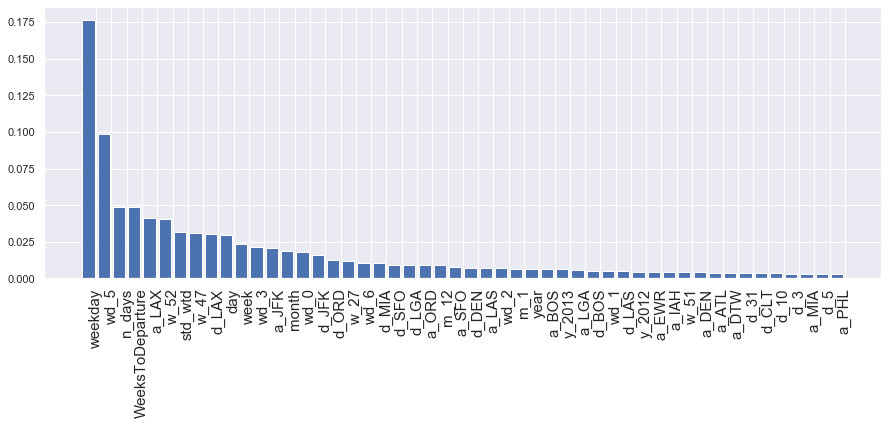

In [35]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

## Building predictive models

### The feature extractor

The feature extractor implements a single <code>transform</code> function. It receives the full pandas object X_df (without the labels). It should produce a numpy array representing the features extracted. If you want to use the (training) labels to save some state of the feature extractor, you can do it in the fit function.

The starting kit feature extractor shows you how to join your data to external data. You will have the possibility to submit a single external csv for each of your submission (so if you have several data sets, you first have to do the join offline, and save it as a csv). In this case it is whether data, joined to the database on the <code>DateOfDeparture</code> and <code>Arrival</code> fields. Attention: when you join the data, make sure that the <b><font color=red>order</font> of the rows in the data frame does not change</b>.

In [36]:
import pandas as pd
import os


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        path = os.path.dirname(__file__)
        data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
        X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
        X_weather = X_weather.rename(
            columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
        X_encoded = pd.merge(
            X_encoded, X_weather, how='left',
            left_on=['DateOfDeparture', 'Arrival'],
            right_on=['DateOfDeparture', 'Arrival'],
            sort=False)

        X_encoded = X_encoded.join(pd.get_dummies(
            X_encoded['Departure'], prefix='d'))
        X_encoded = X_encoded.join(
            pd.get_dummies(X_encoded['Arrival'], prefix='a'))
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)

        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
        X_array = X_encoded.values
        return X_array

In [37]:
# we need this because the global variable __file__ (the path of the current file)
# does not exist if we are in a notebook
__file__ = 'submissions/starting_kit/'
fe = FeatureExtractor()
fe.fit(X_df, y_array)
X_array = fe.transform(X_df)
X_array.shape

(8902, 43)

### The regressor

The regressor should implement an sklearn-like regressor with `fit` and `predict` functions.

In [38]:
from sklearn.svm import SVR
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = SVR()

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator


class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(
            n_estimators=20, max_depth=50, max_features=10)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

In [40]:
reg = Regressor()
reg.fit(X_array, y_array)
y_pred = reg.predict(X_array)

In [41]:
score_type = problem.score_types[0]

In [42]:
score = score_type(y_array, y_pred)
score

0.3195530500055844

In [43]:
X_test_df, y_test_array = problem.get_test_data()

In [44]:
X_test_array = fe.transform(X_test_df)
y_test_pred = reg.predict(X_test_array)
score_type(y_test_array, y_test_pred)

0.8405457663543664

In [45]:
cv = problem.get_cv(X_df, y_array)

In [46]:
for fold in cv:
    print(fold)

(array([1527, 1304, 4252, ..., 3151, 3077, 3023]), array([5590, 2344,  938, ..., 6220, 4046,  958]))
(array([2836, 8896, 8801, ..., 2919, 1608, 2510]), array([  97, 5215, 8350, ..., 3136, 7833, 4932]))
(array([7366, 8531, 7566, ..., 3948, 6159, 8204]), array([2696, 3742, 2039, ..., 7243,  898, 8388]))
(array([2275, 4121, 8842, ..., 4813, 8347, 7834]), array([3557, 4733, 6513, ..., 3732, 8590, 3621]))
(array([2234, 6933, 7735, ..., 1954, 2590, 8468]), array([8403, 2539, 6318, ..., 7136, 2123,  787]))
(array([1337, 4654, 5750, ..., 6708, 6032, 4680]), array([1148, 4736, 3175, ...,  342, 4437, 5412]))
(array([4393, 4923, 7190, ...,  418, 7477, 2455]), array([8019, 2236, 6463, ..., 4189, 8555, 6438]))
(array([8464, 3308, 6072, ..., 3662, 2696, 5690]), array([8298, 4113, 8879, ..., 3936, 3903, 4337]))


In [47]:
cv = problem.get_cv(X_df, y_array)
valid_scores = np.array([])
for fold in cv:
    train_is, valid_is = fold
    X_fold_train = X_df.iloc[train_is]
    y_fold_train = y_array[train_is]
    X_fold_valid = X_df.iloc[valid_is]
    y_fold_valid = y_array[valid_is]
    fe.fit(X_fold_train, y_fold_train)
    X_fold_train_array = fe.transform(X_fold_train)
    reg.fit(X_fold_train_array, y_fold_train)
    X_fold_valid_array = fe.transform(X_fold_valid)
    y_fold_valid_pred = reg.predict(X_fold_valid_array)
    valid_score = score_type(y_fold_valid, y_fold_valid_pred)
    valid_scores = np.append(valid_scores, valid_score)
print('validation scores =', valid_scores)
print('validation score mean =', valid_scores.mean())
print('validation score std =', valid_scores.std())

validation scores = [0.82138409 0.83807857 0.83106554 0.8418912  0.8244098  0.82433667
 0.81539845 0.82056113]
validation score mean = 0.8271406826697156
validation score std = 0.008531182197149819


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py`, `regressor.py`, and `external_data.csv` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.bz2` and `test.csv.bz2` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [48]:
!ramp_test_submission

Testing Number of air passengers prediction
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score   rmse      time
	train  0.220  3.510466
	valid  0.553  4.187824
	test   0.579  1.005212
CV fold 1
	score   rmse      time
	train  0.221  2.624807
	valid  0.573  3.597604
	test   0.575  1.105972
CV fold 2
	score   rmse      time
	train  0.223  2.755380
	valid  0.574  4.118324
	test   0.581  1.006623
CV fold 3
	score   rmse      time
	train  0.215  2.635398
	valid  0.566  2.928734
	test   0.570  0.653809
CV fold 4
	score   rmse      time
	train  0.219  1.861101
	valid  0.558  2.716905
	test   0.580  1.039107
CV fold 5
	score   rmse      time
	train  0.216  2.769918
	valid  0.545  3.050751
	test   0.569  0.852303
CV fold 6
	score   rmse      time
	train  0.229  2.429475
	valid  0.570  4.122761
	test   0.592  0.854349
CV fold 7
	score   rmse      time
	train  0.223  1.482765
	valid  0.562  1.948961
	test   0.588  0.570001
----------

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.

In [49]:
# %load https://raw.githubusercontent.com/paris-saclay-cds/ramp-workflow/master/rampwf/utils/testing.py

In [50]:
# assert_submission()

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good model, you can submit it to [ramp.studio](http://ramp.r0h.eu). First, if it is your first time using RAMP, [sign up](http://ramp.r0h.eu/sign_up), otherwise [log in](http://ramp.r0h.eu/login). Then find an open event on the particular problem, for example, the event [DSSP 6](https://ramp.r0h.eu/events/air_passengers_dsb2019) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://ramp.r0h.eu/events/air_passengers_dsb2019/sandbox) and copy-paste (or upload) [`feature_extractor.py`](http://localhost:8890/edit/submissions/starting_kit/feature_extractor.py), [`regressor.py`](http://localhost:8890/edit/submissions/starting_kit/regressor.py), and [`external_data.csv`](http://localhost:8890/edit/submissions/starting_kit/external_data.csv) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://ramp.r0h.eu/events/air_passengers_dsb2019/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://ramp.r0h.eu/events/air_passengers_dsb2019/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://ramp.r0h.eu/events/air_passengers_dsb2019/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train rmse = 0.748 ± 0.0117
valid rmse = 0.858 ± 0.0111
test rmse = 0.881 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://ramp.r0h.eu/events/air_passengers_dsb2019/leaderboard)) is root mean squared error ("rmse"), so the line that is relevant in the output of `ramp_test_submission` is `valid rmse = 0.858 ± 0.0111`. When the score is good enough, you can submit it at the RAMP.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=air passengers notebook).